### 1. Import and load

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as scistat

covid_totals = pd.read_csv('data/covidtotals720.csv')
covid_totals.set_index('iso_code', inplace=True)
tot_vars = ['total_cases',
            'total_deaths', 'total_cases_pm',
            'total_deaths_pm']
demo_vars = ['population', 'pop_density',
             'median_age', 'gdp_per_capita',
             'hosp_beds']

### 2. Get descriptive stats for the Covid case data.

Create a DataFrame with just the key case data:

In [3]:
covid_totals_only = covid_totals.loc[:, tot_vars]
covid_totals_only.describe()

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
count,2.090000e+02,209.000000,209.000000,209.000000
mean,6.075741e+04,2702.952153,2297.022144,73.636522
std,2.724401e+05,11894.963052,4039.840203,156.341672
min,3.000000e+00,0.000000,1.229000,0.000000
25%,3.420000e+02,9.000000,202.834000,2.809000
50%,2.820000e+03,53.000000,868.866000,15.216000
75%,2.561100e+04,386.000000,2784.865000,58.374000
max,3.247684e+06,134814.000000,35795.159000,1237.551000


### 3. Show more detailed percentile data:

In [4]:
covid_totals_only.quantile(np.arange(0.0, 1.1, 0.1)) 

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
0.0,3.0,0.0,1.2290,0.0000
0.1,63.6,0.0,63.3298,0.0000
0.2,231.2,3.6,144.8176,1.2358
0.3,721.6,14.4,261.5104,3.7636
0.4,1324.4,28.4,378.7776,7.0218
0.5,2820.0,53.0,868.8660,15.2160
0.6,6695.6,116.6,1398.3306,29.3736
0.7,14316.4,279.0,2307.9256,47.7320
0.8,40245.4,885.2,3492.3088,76.2842
0.9,98632.8,4719.0,5407.6504,201.4248


Also show skewness and kurtosis. 

`Skewness` and `kurtosis` describe how symmetrical the distribution is and how fat the tails of the distribution are, respectively. 

Both measures are significantly higher than we would expect if our variables were distributed normally:

In [5]:
covid_totals_only.skew()

total_cases        9.327371
total_deaths       8.126376
total_cases_pm     4.284485
total_deaths_pm    3.910966
dtype: float64

### 4. Test the COVID data for normality.

Use the `Shapiro-Wilk` test from the `scipy` library. 

Print out the p-value from the test. (The `null` hypothesis of a normal distribution can be rejected at the 95% level at any p-value below 0.05): 

In [6]:
def test_norm(var, df):
    stat, p = scistat.shapiro(df[var])
    return p

print("total cases: %.5f" % test_norm("total_cases", covid_totals_only))
print("total deaths: %.5f" % test_norm("total_deaths", covid_totals_only))
print("total cases pm: %.5f" % test_norm("total_cases_pm", covid_totals_only))
print("total deaths pm: %.5f" % test_norm("total_deaths_pm", covid_totals_only))

total cases: 0.00000
total deaths: 0.00000
total cases pm: 0.00000
total deaths pm: 0.00000


### 5. Show normal quantile-quantile plots (`qqplots`) of total cases and total cases per million.

The straight lines show what the distributions would look like if they were normal:

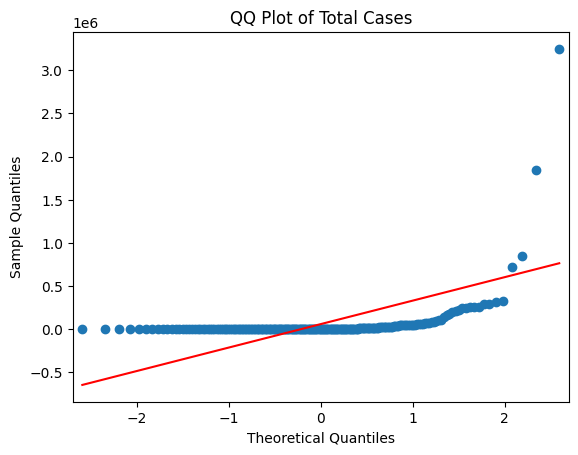

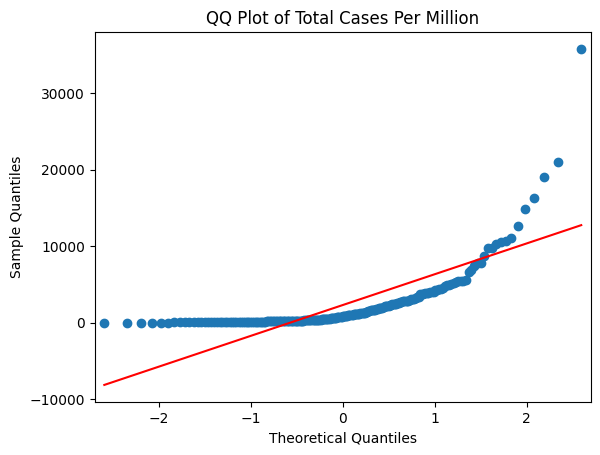

In [7]:
sm.qqplot(covid_totals_only[['total_cases']].sort_values(['total_cases']), line='s')
plt.title('QQ Plot of Total Cases')

sm.qqplot(covid_totals[['total_cases_pm']].sort_values(['total_cases_pm']), line='s')
plt.title('QQ Plot of Total Cases Per Million')

plt.show()

### 6. Show the outlier range for total cases.

One way to define an outlier for a continuous variable is by distance above the third quartile or below the first quartile.

If that distance is more than 1.5 times the interquartile range (the distance between the 1st and the 3rd quartile), that value is considered an outlier.

In this case, since only 0 or positive values are possible, any total cases value above 25,028 is considered an outlier:

In [8]:
third_q, first_q = covid_totals_only.total_cases.quantile(0.75), covid_totals_only.total_cases.quantile(0.25)

interquartile_range = 1.5 * (third_q - first_q)

outlier_high, outlier_low = interquartile_range + third_q, first_q - interquartile_range

print(outlier_low, outlier_high, sep=' <---> ')

-37561.5 <---> 63514.5


### 7. Generate a DataFrame of outliers and write it to Excel.

Iterate over the 4 COVID cases columns. 

Calculate the outliers threshold for each column as we did in the previous step. 

Select from the DataFrame those rows above the high threshold or below the low threshold.

Add columns that indicate the variable examined (`varname`) for outliers and the threshold levels: 

In [28]:
def get_outliers():
    df_out = pd.DataFrame(columns=covid_totals.columns, data=None)
    
    for col in covid_totals_only.columns:
        third_q, first_q = covid_totals_only[col].quantile(0.75), covid_totals_only[col].quantile(0.25)
        interquartile_range = 1.5 * (third_q - first_q)
        outlier_high, outlier_low = interquartile_range + third_q, first_q - interquartile_range
        
        df = covid_totals.loc[(covid_totals[col] > outlier_high) | (covid_totals[col] < outlier_low)]
        df = df.assign(var_name=col, thresh_low=outlier_low, thresh_high=outlier_high)
        
        df_out = pd.concat([
            df_out if not df_out.empty else None, 
            df
        ])
        
    # print(df_out.columns)    
    return df_out

In [29]:
outliers = get_outliers()
outliers.var_name.value_counts()

var_name
total_deaths       41
total_deaths_pm    32
total_cases        29
total_cases_pm     17
Name: count, dtype: int64

In [34]:
outliers.head()

,lastdate,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds,region,var_name,thresh_low,thresh_high
iso_code,,,,,,,,,,,,,,,
ARG,2020-07-12,Argentina,97509.0,1810.0,2157.480,40.048,45195777.0,16.177,31.9,18933.907,5.0,South America,total_cases,-37561.5,63514.5
BGD,2020-07-12,Bangladesh,181129.0,2305.0,1099.822,13.996,164689383.0,1265.036,27.5,3523.984,0.8,South Asia,total_cases,-37561.5,63514.5
BLR,2020-07-12,Belarus,64767.0,459.0,6854.143,48.575,9449321.0,46.858,40.3,17167.967,11.0,Eastern Europe,total_cases,-37561.5,63514.5
BRA,2020-07-12,Brazil,1839850.0,71469.0,8655.698,336.231,212559409.0,25.040,33.5,14103.452,2.2,South America,total_cases,-37561.5,63514.5
CAN,2020-07-12,Canada,107335.0,8773.0,2843.902,232.446,37742157.0,4.037,41.4,44017.591,2.5,North America,total_cases,-37561.5,63514.5


In [33]:
outliers.to_excel('views/outliers_cases.xlsx')

### 8. Look a little more closely at outliers for cases per million.

Use the `var_name` column we created to select the outliers for `total_cases_pm`.

Also show columns (`pop_density` and `gdp_per_capita`) that might help to explain the extreme values and the interquartile range for those columns:

In [35]:
outliers.loc[outliers.var_name == 'total_cases_pm', ['location', 'total_cases_pm', 'pop_density', 'gdp_per_capita']].sort_values(['total_cases_pm'], ascending=False)

,location,total_cases_pm,pop_density,gdp_per_capita
iso_code,,,,
QAT,Qatar,35795.159,227.322,116935.600
SMR,San Marino,21038.364,556.667,56861.470
BHR,Bahrain,19082.231,1935.907,43290.705
CHL,Chile,16322.745,24.282,22767.037
VAT,Vatican,14833.127,NaN,NaN
KWT,Kuwait,12658.284,232.128,65530.537
AND,Andorra,11065.812,163.755,NaN
OMN,Oman,10710.994,14.980,37960.709
ARM,Armenia,10593.831,102.931,8787.580


In [37]:
covid_totals[['pop_density', 'gdp_per_capita', 'total_cases_pm']].quantile([0.25, 0.5, 0.75])

,pop_density,gdp_per_capita,total_cases_pm
0.25,37.4160,4485.32900,202.834
0.50,87.2500,13031.52650,868.866
0.75,213.5355,27882.13375,2784.865


### 9. Show a histogram of total cases:

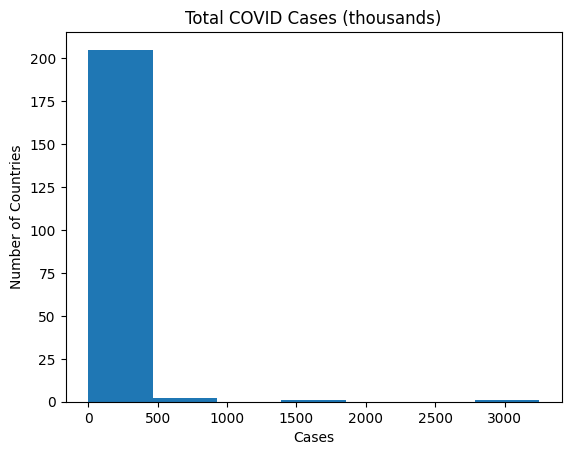

In [38]:
plt.hist(covid_totals_only['total_cases'] / 1000, bins=7)
plt.title('Total COVID Cases (thousands)')
plt.xlabel('Cases')
plt.ylabel('Number of Countries')
plt.show()